In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
import matplotlib
matplotlib.rcdefaults()
import sys
#sys.path.insert(1, '/home/suarez08/PhD_PINNs/PIPS_framework')
from sobolev import Sobolev
import time
import tensorflow as tf
from spline_integration import ikp,ikp2

0.0


In [ ]:
# Properties class to store the properties of each particle
class Props:
    def __init__(self, field_val, derivs):
        self.field = field_val
        self.field_derivative = derivs

In [ ]:
class Particle:
    def __init__(self, position, properties):
        self.position = position
        self.properties = properties

    def interact(self, other_particle):
        pass

    def evolve(self):
        pass


In [ ]:
class ParticleSet:

    def __init__(self, positions, properties):
        # positions: array of shape (N, d)
        # properties: array of shape (N)
        self.num_particles = positions.shape[0]
        self.spatial_dimesion = positions.shape[1]
        self.particles = []
        for i in range(self.num_particles):
            self.particles.append(Particle(positions[i,:], properties[i]))

    def update_once(self):
        pass

    def compute_derivatives(self, verlet_list, deriv_func, eps, V):
        for p_idx, p in enumerate(self.particles):
            result = 0.0
            neighbours = verlet_list.neighbours[p_idx]
            for q_idx in neighbours:
                q = self.particles[q_idx]
                if q != p:
                    z = p.position[0] - q.position[0]
                    result += q.properties.field * deriv_func(z, eps) * V
            p.properties.field_derivative = result
        return

In [ ]:
class CellList:

    def __init__(self, particle_set, rc):
        self.cells = {}
        self.construct(particle_set, rc)

    def construct(self, particle_set, rc):
        for idx, p in enumerate(particle_set.particles):
            cell_index_x = np.floor((p.position) / rc).astype(int)
            cell_index = cell_index_x[0]
            if cell_index in self.cells.keys():
                self.cells[cell_index].append(idx)
            else:
                self.cells[cell_index] = [idx]

    def particles_in(self, cell_index):
        if cell_index in self.cells.keys():
            return self.cells[cell_index]
        else:
            return []


    def neighbourhood(self, cell_index):
        cell_index
        cell_index_x = cell_index[0]
        neighbour_list = []
        for lx in [-1, 0,1]:
            neighbour_list.extend(self.particles_in(cell_index_x + lx))

        return neighbour_list

In [ ]:
class VerletList:

    def __init__(self, particle_set, cell_list, rc):
        self.neighbours = {}
        self.construct(particle_set, cell_list, rc)

    def construct(self, particle_set, cell_list, rc):
        for p_id, p in enumerate(particle_set.particles):
            self.neighbours[p_id] = []
            cell_index_x = np.floor((p.position) / rc).astype(int)
            cell_index = cell_index_x
            for q_id in cell_list.neighbourhood(cell_index):
                q = particle_set.particles[q_id]
                if np.linalg.norm(p.position[0]-q.position[0]) <= rc:
                    self.neighbours[p_id].append(q_id)

In [ ]:
def f(x):
    return x**2
def dxf(x):
    return 2*x
def kernel(z, eps):
    alphad = 2.0/eps
    z = np.abs(z)
    if z < 0.5*eps:
        return alphad*(2.0/3.0 - (2.0*z/eps)**2 + 0.5*(2.0*z/eps)**3)
    elif z >= 0.5*eps and z < eps:
        return alphad*(((1.0/6.0)*(2.0-2.0*z/eps)**3))
    else:
        return 0.0

def deriv_kernel(z, eps):
    if z!=0:
        sign = z/np.abs(z)
    else:
        sign = 1
    z = np.abs(z)
    alphad = sign*2.0/eps
    if z < 0.5*eps:
        return alphad*((-8.0*z/(eps**2)) + (12.0*z**2/eps**3))
    elif z >= 0.5*eps and z < eps:
        return alphad*(-1*(2.0-2.0*z/eps)**2/eps)
    else:
        return 0.0
def f(x):
    return 1/(1+x**2)

In [ ]:
support=2.0
def M_sph(x_t,x_int):
    #positions = np.linspace(-1,1,N)
    h=abs(x_t[1]-x_t[0])
    rc = 5.0*h
    properties = []
    x_t = x_t.reshape(len(x_t),1)
    for idx in range(len(x_t)):
        p = Props(x_t[idx]**2, 0.0)
        properties.append(p)

    # Initial particle set
    pset = ParticleSet(x_t, properties)
    cell_list = CellList(pset, rc)
    verlet_list = VerletList(pset, cell_list, rc)
    # Compute the first derivative using SPH kernel
    V = h
    eps = support*h
    F = []
    Fx = []
    M = np.zeros([len(x_int),len(x_t), len(x_t)])
    for i in range(len(x_int)):
        x_i = x_int[i]#positions.T[0][i]+0.1#x[i]
        result = 0.0
        resultdx = 0.0
        IDX = np.floor((x_i) / rc).astype(int)
        neighbours = cell_list.neighbourhood([IDX])
        for j, i_idx in enumerate(neighbours):
            for j, j_idx in enumerate(neighbours):
                qi = pset.particles[i_idx]
                qj = pset.particles[j_idx]
                zi = x_i - qi.position[0]
                zj = x_i - qj.position[0]
                M[i,i_idx,j_idx] = kernel(zi, eps)* kernel(zj, eps) * V**2*w_1d[i]
    return M

In [ ]:
deg_quad = 30
sob_param = Sobolev(deg=deg_quad, dim=1)
x_plt, _, _, x_int, _, _ = sob_param.get_quad()
w_1d = np.array(sob_param.get_leja_weights())
dx =sob_param.diff.diffs(np.array([[1]]))

In [ ]:
N = 100
x_t = np.linspace(-1,1,N)
M_gl = np.sum(M_sph(x_t, x_int), axis = 0)

In [ ]:
def M_sph_wn(x_t,x_int):
    #positions = np.linspace(-1,1,N)
    h=abs(x_t[1]-x_t[0])
    rc = 5.0*h
    properties = []
    x_t = x_t.reshape(len(x_t),1)
    for idx in range(len(x_t)):
        p = Props(x_t[idx]**2, 0.0)
        properties.append(p)

    # Initial particle set
    pset = ParticleSet(x_t, properties)
    cell_list = CellList(pset, rc)
    verlet_list = VerletList(pset, cell_list, rc)
    # Compute the first derivative using SPH kernel
    V = h
    eps = support*h
    F = []
    Fx = []
    M = np.zeros([len(x_int),len(x_t), len(x_t)])
    for i in range(len(x_int)):
        x_i = x_int[i]#positions.T[0][i]+0.1#x[i]
        result = 0.0
        resultdx = 0.0
        IDX = np.floor((x_i) / rc).astype(int)
        for k in range(len(pset.particles)):
            for j in range(len(pset.particles)):
                qi = pset.particles[k]
                qj = pset.particles[j]
                zi = x_i - qi.position[0]
                zj = x_i - qj.position[0]
                M[i,k,j] = kernel(zi, eps)* kernel(zj, eps) * V**2*w_1d[i]
    return M

In [ ]:
support=2
def M_an (N):
  positions = np.linspace(-1,1,N)
  positions = positions.reshape(N,1)
  h=positions[1]-positions[0]
  eps=support*h
  rc = 5.0*h
  M=np.zeros((N,N))
  for i in range(N):
    for j in range(N):
      lam1=0.0
      lam2 = 0.0
      x_i = positions[i].item()
      x_j = positions[j].item()
      M[i][j]=ikp(x_i,x_j,eps.item())*h**2
      if x_i==-1:
        for k in range(3):
          x_k = positions[k].item()
          lam1 += kernel(abs(x_i-x_k),eps)*h
      if x_j == -1:
        for k in range(3):
          x_k = positions[k].item()
          lam2 += kernel(abs(x_j-x_k),eps)*h
      if x_i == 1:
        for k in range(3):
          x_k = positions[N-1-k].item()
          lam1 += kernel(abs(x_i-x_k),eps)*h
      if x_j ==1:
        for k in range(3):
          x_k = positions[N-k-1].item()
          lam2 += kernel(abs(x_j-x_k),eps)*h
      if x_i != -1 and x_i != 1:
        lam1 = 1
      if  x_j != -1 and x_j != 1:
        lam2 = 1
      M[i][j]=M[i][j]/(lam1*lam2)
  return M

def M_an2 (N):
  positions = np.linspace(-1,1,N)
  positions = positions.reshape(N,1)
  h=positions[1]-positions[0]
  eps=support*h
  rc = 5.0*h
  M=np.zeros((N,N))
  for i in range(N):
    for j in range(N):
      M[i][j]=ikp2(positions[i].item(),positions[j].item(),eps.item())*h**2
  return M

In [ ]:
def f(x):
    return x**2

In [ ]:
def anaint(N):
  s=int(N/100)
  x_t = np.linspace(-1,1,N)
  h=x_t[1]-x_t[0]
  x=np.linspace(-1-s*h,1+s*h,N+s)
  M=M_an(N+s)
  M2=M_an2(N+s)
  fx=f(x)
  fx=np.reshape(fx,(N+s,1))
  return np.matmul(fx.T,np.matmul(M,fx)),np.matmul(fx.T,np.matmul(M2,fx))#np.matmul(f_x.T,np.matmul(m,f_x)),x[k],x[N-k-1]

In [ ]:
def integral_val(l,r):
  return (r**5 - l**5)/5

In [ ]:
N=(np.linspace(100,3000,4))
error1=[]
error2=[]
for i in range(len(N)):
    I,i2=anaint(int(N[i]))
    print(I,i2)
    error1.append(abs(I[0][0]-integral_val(-1,1)))
    error2.append(abs(i2[0][0]-integral_val(-1,1)))

[[0.43750515]] [[0.44173899]]
[[0.43035631]] [[0.43074165]]
[[0.43185216]] [[0.43205458]]


KeyboardInterrupt: ignored

ValueError: ignored

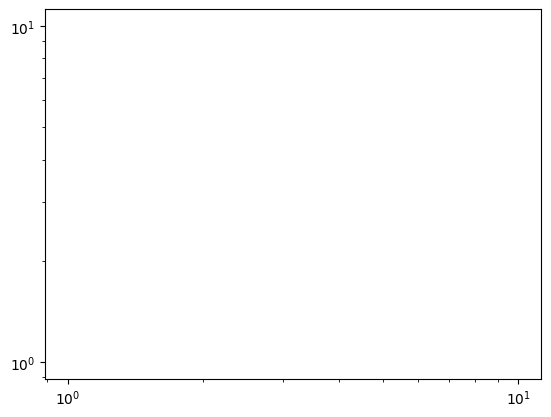

In [ ]:
plt.loglog(N,error1,label='errors')
plt.loglog(N,error2,label='errors2')
plt.loglog(N,1/N**2,label='2nd order')
plt.loglog(N,1/N,label='1nd order')
plt.legend()

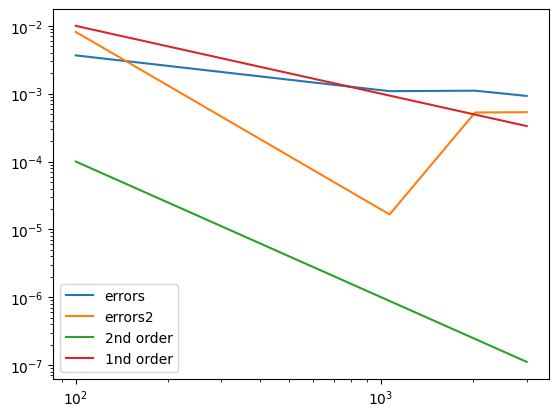

In [ ]:
plt.loglog(N,error1,label='errors')
plt.loglog(N,error2,label='errors2')
plt.loglog(N,1/N**2,label='2nd order')
plt.loglog(N,1/N,label='1nd order')
plt.legend()

In [ ]:
error1

[0.10174013994903142,
 0.008128003503947379,
 0.003821158433217786,
 0.0023947492543867077]

In [ ]:
I[0][0],integral_val(-1,1)

(0.40239474925438673, 0.4)

In [ ]:
I[0][0],integral_val(-1,1)

(0.3990728912116614, 0.4)

In [ ]:
def anaint(N):
  s=2
  x_t = np.linspace(-1,1,N)
  h=x_t[1]-x_t[0]
  x=np.linspace(-1-s*h,1+s*h,N+s)
  M=M_an(N+s)
  M2=M_an2(N+s)
  fx=f(x)
  fx=np.reshape(fx,(N+s,1))
  return np.matmul(fx.T,np.matmul(M,fx)),np.matmul(fx.T,np.matmul(M2,fx))#np.matmul(f_x.T,np.matmul(m,f_x)),x[k],x[N-k-1]

In [ ]:
N=(np.linspace(100,3000,4))
error1=[]
error2=[]
for i in range(len(N)):
    I,i2=anaint(int(N[i]))
    print(I,i2)
    error1.append(abs(I[0][0]-integral_val(-1,1)))
    error2.append(abs(i2[0][0]-integral_val(-1,1)))

eps= [0.03960396]
eps= [0.03960396]
[[0.46410246]] [[0.4776767]]
eps= [0.00374883]
eps= [0.00374883]
[[0.40477529]] [[0.40589646]]
eps= [0.00196657]
eps= [0.00196657]
[[0.40204191]] [[0.40262609]]
eps= [0.00133289]


KeyboardInterrupt: ignored

In [ ]:
I[0][0]

0.40969114456820843

In [ ]:
i2[0][0]

0.4026260868089374

In [ ]:
I[0][0],i2[0],[0]

(0.4020419125783432, array([0.40262609]), [0])

In [ ]:
I[0][0],i2[0][0]

(0.4020419125783432, 0.4026260868089374)